In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def max_length_text(df):
    max_length = 0
    for i in range(df.shape[0]):
        length = np.size(word_tokenize(df.at[i, 'text']))
        if length > max_length: max_length = length
    return max_length

In [4]:
def sequence_length_histogram(df):
    lengths = []
    for i in range(df.shape[0]):
        length = np.size(word_tokenize(df.at[i, 'text']))
        lengths.append(length)
    
    plt.hist(lengths, bins = 20)
    plt.show()
    return lengths

In [5]:
def text_normalization(data):
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].apply((lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)))

In [6]:
def remove_stop_words(data, language, get_tokenize):
    stopwords = nltk.corpus.stopwords.words(language)
    if get_tokenize:
        for i in range(data.shape[0]):
            data.at[i, 'text'] = [word for word in nltk.word_tokenize(data.at[i, 'text']) if word not in stopwords]
    else:
        for i in range(data.shape[0]):
            data.at[i, 'text'] = [word for word in nltk.word_tokenize(data.at[i, 'text']) if word not in stopwords]
            data.at[i, 'text'] = ' '.join(data.at[i, 'text'])

In [7]:
def apply_stemming(data, language):
    stemmer = SnowballStemmer(language)
    for i in range(data.shape[0]):
         data.at[i, 'text'] = (' '.join([stemmer.stem(word) for word in data.at[i, 'text'].split()]))

#### get_matrix representation | BoW and Tf-idf for Classic ML

In [8]:
def get_matrix(data, representation, vocabulary_length, stemming, remove_stopwords, language):

    df = data.copy(deep = True)
    
    text_normalization(df) # Text normalization
    
    # Stop_words
    if remove_stopwords:
        remove_stop_words(df, language, False)
    
    # Stemming
    if stemming:
        apply_stemming(df, language)
    
    # Word representation
    if representation == 'BoW':
        count_vectorizer = CountVectorizer(max_df = 0.9, max_features = vocabulary_length, min_df = 0)
        #count_vectorizer = CountVectorizer(max_features = vocabulary_length)
        matrix = count_vectorizer.fit_transform(df.text)
        
    elif representation == 'tf-idf':
        tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, max_features = vocabulary_length, min_df = 0, use_idf = True)
        #tfidf_vectorizer = TfidfVectorizer(max_features = vocabulary_length, use_idf=True)
        matrix = tfidf_vectorizer.fit_transform(df.text)
    
    return matrix, df

#### Preprocessing for RNN - LSTM; CNN

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
def get_input(data, stemming, remove_stopwords, vocabulary_length, max_length_sequence, language):
    
    df = data.copy(deep = True)
    
    text_normalization(df) # Text normalization
    
    # Stemming
    if stemming:
        apply_stemming(df, language)
    
    # Stop_words
    if remove_stopwords:
        remove_stop_words(df, language, True)
        
    # Tokenizer
    tokenizer = Tokenizer(num_words = vocabulary_length)
    tokenizer.fit_on_texts(df.text)
    X = tokenizer.texts_to_sequences(df.text)
    
    # Padding
    X = pad_sequences(X, maxlen = max_length_sequence, padding = 'post', truncating = 'post')
    
    return X, df

In [11]:
def get_input_share_tokenizer(data_1, data_2, stemming, remove_stopwords, vocabulary_length, max_length_sequence, language):
    
    df1 = data_1.copy(deep = True)
    df2 = data_2.copy(deep = True)
    
    text_normalization(df1) # Text normalization
    text_normalization(df2)
    
    # Stemming
    if stemming:
        apply_stemming(df1, language)
        apply_stemming(df2, language)
    
    # Stop_words
    if remove_stopwords:
        remove_stop_words(df1, language, True)
        remove_stop_words(df2, language, True)
        
    # Tokenizer
    tokenizer = Tokenizer(num_words = vocabulary_length)
    tokenizer.fit_on_texts(df1.text)
    X_1 = tokenizer.texts_to_sequences(df1.text)
    X_2 = tokenizer.texts_to_sequences(df2.text)
    
    # Padding
    X_1 = pad_sequences(X_1, maxlen = max_length_sequence, padding = 'post', truncating = 'post')
    X_2 = pad_sequences(X_2, maxlen = max_length_sequence, padding = 'post', truncating = 'post')
    
    return X_1, X_2, df1, df2

#### Tests

#### Spanish Dataset

In [11]:
dataset = pd.read_csv('../data/Merged/spanish_dataset.csv')
dataset

,text,label
0,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",1
1,"La palabra ""haiga"", aceptada por la RAE La Rea...",1
2,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,1
3,UNAM capacitará a maestros para aprobar prueba...,0
4,Alerta: pretenden aprobar libros escolares con...,1
...,...,...
2566,"Recuperamos la historia de Aleixandra, la jove...",0
2567,"Reproches, tensión y sinceridad: la comida en ...",0
2568,"RT @ElMundoOpinion: ""PSOE, PP, Ciudadanos y Vo...",0
2569,Rusia cita al embajador español por unas decla...,0


In [11]:
max_length_text(dataset)

2865

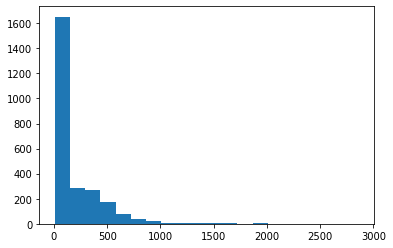

193.06


In [21]:
lengths = sequence_length_histogram(dataset)
print(round(np.mean(lengths), 3))

In [22]:
print(dataset.at[0, 'text'])

RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONARIO DEL IDIOMA ESPAÑOL COMO DEFINICIÓN DE "MUJER PROBLEMÁTICA"
España.- El presidente de la Real Academia Española (RAE), Darío Villanueva, informó en conferencia de prensa que a partir del próximo mes se incluirá el término "Lady" como una nueva palabra en el diccionario del idioma español.
Darío señaló que "Lady" servirá para definir a una "mujer problemática" o a una "mujer que causa problemas", y mencionó que esta palabra será una de las pocas que también se utilizan en el idioma inglés pero que en castellano tiene un significado diferente:
"Son contadas las palabras del idioma inglés que se utilizan en el español pero que tienen otro significado. Con la globalización las personas han comenzado a adoptar términos anglosajones pero los utilizan con su significado real, sin embargo en este caso la expresión Lady no significará lo mismo que en su idioma original ("dama" en inglés) sino que se usará para definir a una mujer que es problemáti

In [23]:
X, df = get_input(dataset, False, True, 10000, 500, language = 'spanish')
# X, df = get_input(dataset, True, True, 40000, 2900, language = 'spanish')
print(df.at[0, 'text'])
print(df.shape)

['rae', 'incluirá', 'palabra', 'lady', 'diccionario', 'idioma', 'español', 'definición', 'mujer', 'problemática', 'españa', 'presidente', 'real', 'academia', 'española', 'rae', 'darío', 'villanueva', 'informó', 'conferencia', 'prensa', 'partir', 'próximo', 'mes', 'incluirá', 'término', 'lady', 'nueva', 'palabra', 'diccionario', 'idioma', 'español', 'darío', 'señaló', 'lady', 'servirá', 'definir', 'mujer', 'problemática', 'mujer', 'causa', 'problemas', 'mencionó', 'palabra', 'pocas', 'utilizan', 'idioma', 'inglés', 'castellano', 'significado', 'diferente', 'contadas', 'palabras', 'idioma', 'inglés', 'utilizan', 'español', 'significado', 'globalización', 'personas', 'comenzado', 'adoptar', 'términos', 'anglosajones', 'utilizan', 'significado', 'real', 'embargo', 'caso', 'expresión', 'lady', 'significará', 'mismo', 'idioma', 'original', 'dama', 'inglés', 'sino', 'usará', 'definir', 'mujer', 'problemática', 'acostumbra', 'causar', 'problemas', 'alborotos', 'gente', 'podrá', 'decirle', 'lad

In [24]:
print(X.shape)
print(len(X))
print(X[0], len(X[0]))
print(X[0,:])

(2571, 500)
2571
[1328 3124  729 2909 2261 1639  232 4706   91 5246   54    9  268  975
  352 1328 4300 5247  359  330  176  138  166  122 3124 1786 2909   71
  729 2261 1639  232 4300  123 2909 3125 1961   91 5246   91  548  326
  303  729 1484 1962 1639  645 5942 3126 1485  463 1639  645 1962  232
 3126 9847   17 2544 3939 1038 1962 3126  268   68   34 1329 2909   56
 1639 2262  481  645  100 4707 1961   91 5246 9848 2411  326   63  264
 3649 2909 9849 9850  464  838 4708 8041  464  170  315 1786 4301 9851
  729 1559 1639  645   26 4302 2261 2711  352 6792    5  729  265 5942
 3126 4303 1169 5247  769  104 4706  265 4304  887  534 2909 4708    1
 8042 2545   91 8043 5246    1 8042 2545   91  548  326    1 8042 2545
   91 5943 2411 2263 4708   27 9852 2712 9853  124 1285   31 5248    1
 8042 2545   91 5249  646 1170  861 2263    9  123  564   80 1328 2713
 1787  729   26   97 1127 6793 1330 1786  574    2 4707  167  713 6794
 1039  861 4709 4706 3125 1961 9854 5246   11  215 4300  492

In [25]:
print(X[1], len(X[1]))

[ 729 6795 6793 1328  268  975 2711 1328 3379  223 6795 5944   40   17
 9857 1128 9858 4710   53   42  279   81 8044 2711 9859   58  400  285
    8 1012  437 1328 3380  152   20 3381 1286 1099  975 2711   26 8045
 5944 1245   21 2714   17  493  493 6796 1963 1716 5945 5250  335 5946
 4305   85 6795  190 2910 5946 4305 6795 8046  463 3379 1328 5251  794
  152  289 5947  770  401  401  224  729  534  362    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

#### English Dataset

In [12]:
english_dataset = pd.read_csv('../data/Merged/english_dataset.csv')
english_dataset

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
51228,The State Department told the Republican Natio...,0
51229,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
51230,Anti-Trump Protesters Are Tools of the Oligar...,1
51231,"ADDIS ABABA, Ethiopia —President Obama convene...",0


In [11]:
max_length_text(english_dataset)

23950

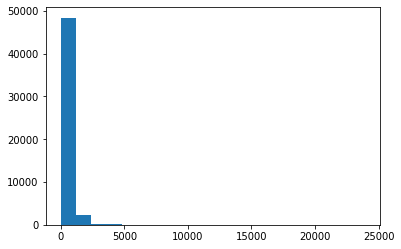

508.65


In [12]:
lengths = sequence_length_histogram(english_dataset)
print(round(np.mean(lengths), 3))

In [13]:
print(english_dataset.at[0, 'text'])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [14]:
X, df = get_input(english_dataset, False, True, 10000, 1500, language = 'english')
print(df.at[0, 'text'])
print(df.shape)

['donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', '2018', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', '2018', 'great', 'year', 'america', 'donald', 'j', 'trump', 'realdonaldtrump', 'december', '31', '2017trump', 'tweet', 'went', 'welll', 'expectwhat', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'trump', 'lack', 'decency', 'even', 'allow', 'rise',

In [15]:
print(X.shape)
print(len(X))
print(X[0], len(X[0]))
print(X[0,:])

(51233, 1500)
51233
[  19    2 2225 ...    0    0    0] 1500
[  19    2 2225 ...    0    0    0]


#### Comparing Original English Dataset with Translated Dataset

In [13]:
translated_dataset = pd.read_csv('../data/Merged/spanish_t_dataset.csv')
translated_dataset

,text,label
0,"RAE WILL INCLUDE THE WORD ""LADY"" IN THE SPANIS...",1
1,"The word ""haiga"", accepted by the RAE The Roya...",1
2,YORDI ROSADO WILL WRITE AND DESIGN THE NEW SEP...,1
3,UNAM will train teachers to pass the Pisa test...,0
4,Alert: they intend to approve school books wit...,1
...,...,...
2566,"We recover the story of Aleixandra, the 21-yea...",0
2567,"Reproaches, tension and sincerity: the meal in...",0
2568,"RT @ElMundoOpinion: ""PSOE, PP, Ciudadanos and ...",0
2569,Russia quotes the Spanish ambassador for some ...,0


In [14]:
df1 = english_dataset.copy(deep = True)
df2 = translated_dataset.copy(deep = True)

language = 'english'
vocabulary_length = 10000

text_normalization(df1) 
text_normalization(df2) 

remove_stop_words(df1, language, True)
remove_stop_words(df2, language, True)

tokenizer_df1 = Tokenizer(num_words = vocabulary_length)
tokenizer_df1.fit_on_texts(df1.text)

tokenizer_df2 = Tokenizer(num_words = vocabulary_length)
tokenizer_df2.fit_on_texts(df2.text)

#tokenizer.get_config()

In [ ]:
tokenizer_df2.get_config()

In [15]:
vocab_list_df1 = list(tokenizer_df1.word_index.keys())
vocab_list_df2 = list(tokenizer_df2.word_index.keys())
print(len(vocab_list_df1), len(vocab_list_df2))

262793 26125


In [28]:
print(vocab_list_df1[:10] ,vocab_list_df2[:10])

['said', 'trump', '’', '“', '”', 'us', 'would', 'president', 'people', 'one'] ['number', 'one', 'de', 'mexico', 'said', 'people', 'would', 'also', 'years', 'la']


Taking into account all the words found by the tokenizer

In [31]:
count = 0
for word in vocab_list_df2:
    if word in vocab_list_df1: count += 1
print(count, round((count*100)/len(vocab_list_df2), 3))

18786 71.908


Taking into account the 10000 most frequent words

In [33]:
count = 0
vocab_list_df1_10k = vocab_list_df1[:vocabulary_length]
vocab_list_df2_10k = vocab_list_df2[:vocabulary_length]

for word in vocab_list_df2_10k:
    if word in vocab_list_df1_10k: count += 1
print(count, round((count*100)/len(vocab_list_df2_10k), 3))

6002 60.02
